In [1]:
# Generales
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pydot as pyd
import time
import joblib

# image preprocessing
import os
import sys
import shutil
import glob
import matplotlib.image as mpimg
from PIL import Image

#sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#keras
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout, BatchNormalization

# keras utils
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils.vis_utils import plot_model

#keras VGG16
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

# tensorflow
import tensorflow as tf
from tensorflow.random import set_seed

#cv2
import cv2
from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%env name=samples1_512_4VR_equiv
!echo $name

env: name=samples1_512_4VR_equiv
samples1_512_4VR_equiv


In [4]:
# copy samples file to directory
!cp ./drive/Shareddrives/Memoria/samples/$name.zip ./$name.zip

!unzip -o -q $name.zip -d ./samples

In [5]:
set_seed(42)
np.random.seed(42)

In [6]:
# Constants

# dirs
inp_img_dir = "./samples/"
out_dir = ""

# init
start_num = 1

height, width = 32, 32

# placeholder
r = "rule_"

# Classes
class1 = [0, 255,
        8, 64, 239, 253,
        32, 251,
        40, 96, 235, 249,
        128, 254,
        136, 192, 238, 252,
        160, 250,
        168, 224, 234, 248]

class2 = [1, 127,
        2, 16, 191, 247,
        3, 17, 63, 119,
        4, 223,
        5, 95,
        6, 20, 159, 215,
        7, 21, 31, 87,
        9, 65, 111, 125,
        10, 80, 175, 245,
        11, 47, 81, 117,
        12, 68, 207, 221,
        13, 69, 79, 93,
        14, 84, 143, 213,
        15, 85,
        19, 55,
        23,
        24, 66, 189, 231,
        25, 61, 67, 103,
        26, 82, 167, 181,
        27, 39, 53, 83,
        28, 70, 157, 199,
        29, 71,
        33, 123,
        34, 48, 187, 243,
        35, 49, 59, 115,
        36, 219,
        37, 91,
        38, 52, 155, 211,
        42, 112, 171, 241,
        43, 113,
        44, 100, 203, 217,
        46, 116, 139, 209,
        50, 179,
        51,
        56, 98, 185, 227,
        57, 99,
        58, 114, 163, 177,
        62, 118, 131, 145,
        72, 237,
        73, 109,
        74, 88, 173, 229,
        76, 205,
        77,
        78, 92, 141, 197,
        94, 133,
        104, 233,
        108, 201,
        130, 144, 190, 246,
        132, 222,
        134, 148, 158, 214,
        138, 174, 208, 224,
        140, 196, 206, 220,
        142, 212,
        152, 188, 194, 230,
        154, 166, 180, 210,
        156, 198,
        162, 176, 186, 242,
        164, 218,
        170, 240,
        172, 202, 216, 228,
        178,
        184, 226,
        200, 236,
        204,
        232]
class3 = [18, 183,
        22, 151,
        30, 86, 135, 149,
        45, 75, 89, 101,
        60, 102, 153, 195,
        90, 165,
        105,
        122, 161,
        126, 129,
        146, 182,
        150]
class4 = [41, 97, 107, 121,
        54, 147,
        106, 120, 169, 225,
        110, 124, 137, 193]

## Dataset Generation

In [7]:
def getPics(classRules, samplesDir):
    classImgs = []

    for r in classRules:
        imgsDir = samplesDir + f'rule_{str(r)}/'
        classImgs += [imgsDir + f for f in os.listdir(imgsDir)]
    return classImgs


c1_img_list = getPics(class1 + class2 + class3, inp_img_dir)
c4_img_list = getPics(class4, inp_img_dir)

## Data Prep

In [8]:
len(c1_img_list), len(c4_img_list)

(61952, 60865)

In [9]:
files_target = [np.full(len(c1_img_list), '1', dtype=str),
                np.full(len(c4_img_list), '4', dtype=str) ]
[x.shape[0] for x in files_target]

[61952, 60865]

In [10]:
# Data selection

c1_x = c1_img_list.copy()
c4_x = c4_img_list.copy()

c1_y = files_target[0].copy()
c4_y = files_target[1].copy()

In [11]:
c_x = np.array(c1_x + c4_x)
c_y = np.concatenate((c1_y, c4_y))

In [12]:
dataset = pd.DataFrame({'img':c_x, 'class':c_y})
dataset = dataset.sample(frac=1)[:100000]
dataset

,img,class
300,./samples/rule_255/255_000_0121_7629.png,1
79038,./samples/rule_121/121_000_0207_9220.png,4
35683,./samples/rule_114/114_000_0074_4576.png,1
108816,./samples/rule_110/110_000_0105_349.png,4
6203,./samples/rule_1/1_000_0190_8937.png,1
...,...,...
8951,./samples/rule_4/4_000_0030_7136.png,1
4743,./samples/rule_160/160_000_0120_9298.png,1
62495,./samples/rule_41/41_000_0182_3670.png,4
7101,./samples/rule_16/16_000_0205_4490.png,1


In [13]:
dataset['class'].value_counts()

1    50397
4    49603
Name: class, dtype: int64

## Data Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(dataset['img'].values, dataset['class'].values, test_size=0.33, random_state=42)

# Reshape

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# one hot encoding
enc = OneHotEncoder(sparse=False)
enc.fit(y_train)

# save encode
joblib.dump(enc, './drive/Shareddrives/Memoria/encodings/encoder' + '_VGG_equiv_V2_4vr' + '.joblib')

# transform data
y_train = enc.transform(y_train)

# print(pd.DataFrame(y_train, columns=list(enc.categories_[0])).head())

# tranform encoding for test data
y_test = enc.transform(y_test)
# to print the encoded features for train data
print(pd.DataFrame(y_test, columns=list(enc.categories_[0])).head())

     1    4
0  0.0  1.0
1  1.0  0.0
2  0.0  1.0
3  1.0  0.0
4  0.0  1.0


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
X_train[0], y_train[0]

('./samples/rule_106/106_000_0090_5356.png', array([0., 1.]))

## Images

In [16]:
def getImages(files):
    img_list = []

    for img in files:
        img1 = load_img(out_dir + img, color_mode='rgb')
        x = img_to_array(img1) / 255

        img_list.append(x)

    return np.array(img_list)

In [17]:
# Images Preview
def imagePreview(imgsArr):
    imgs_show = [imgsArr[0], imgsArr[50], imgsArr[2589], imgsArr[-4]]
    plt.figure(figsize=(16,8))
    columns = 4

    for i, image in enumerate(imgs_show):
        plt.subplot(len(imgs_show) // columns + 1, columns, i + 1)

        plt.imshow(array_to_img(image))

    plt.figure()
    plt.show()

In [18]:
X_train = getImages(X_train)

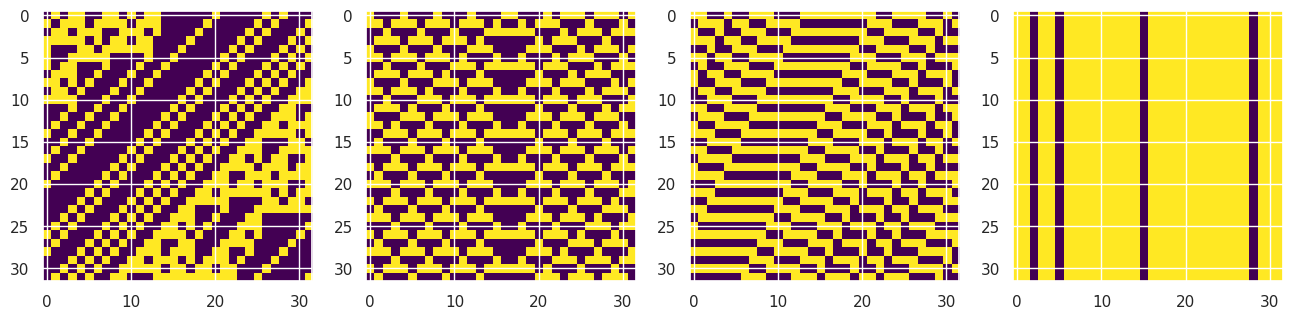

<Figure size 640x480 with 0 Axes>

In [19]:
imagePreview(X_train)

In [20]:
X_test = getImages(X_test)

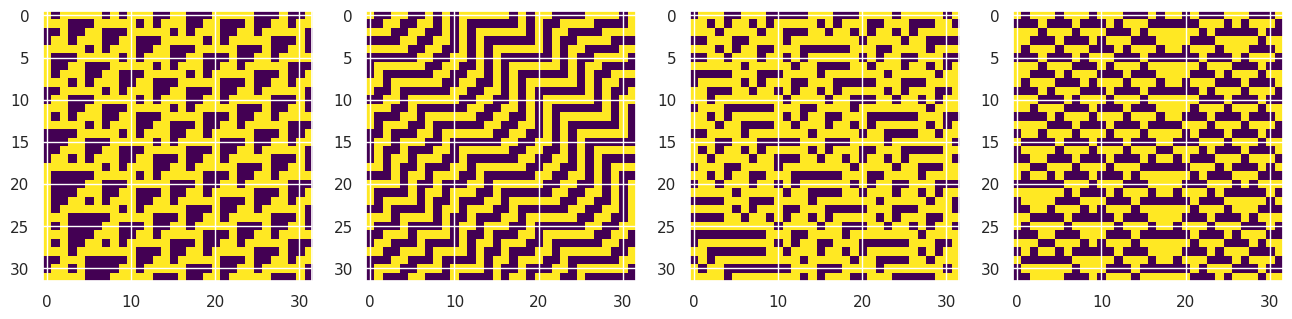

<Figure size 640x480 with 0 Axes>

In [21]:
imagePreview(X_test)

In [22]:
X_train[0].shape

(32, 32, 3)

## Training

In [23]:
# parameters
kernel = 3
stride = 2

# input
input_shape = (height, width, 3)

vgg = VGG16(weights='imagenet', input_shape=input_shape, include_top=False)
# Make all layers untrainable
for layer in vgg.layers[:]:
    layer.trainable = False

output = vgg.get_layer('block5_pool').output
output = Flatten(name='new_flatten')(output)
output = Dense(1024, activation='relu', name='new_fc')(output)
output = Dense(2, activation='softmax')(output)
vgg = Model(vgg.input, output)


vgg.get_layer('new_fc').trainable = True

58889256/58889256 [==============================] - 0s 0us/step


In [24]:
# Model
save_dir = './drive/Shareddrives/Memoria/code/best_models/VGG_equiv_V2_4vr_best.h5'

# 1e-2
opt = Adam(learning_rate=1e-2, amsgrad=True)
met = tf.keras.metrics.CategoricalAccuracy()

vgg.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=[met]
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir,
                            monitor='val_categorical_accuracy',
                            verbose=1,
                            save_best_only=True,
                            mode='max')

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='max',
                                      verbose=1,
                                      patience=15)

callbacks_list = [checkpoint, es]

hist = vgg.fit(x = X_train,
               y = y_train,
               validation_data=([X_test], y_test),
               # ep 50, b 12
               epochs=100,
               batch_size=12,
               verbose=1,
               callbacks=callbacks_list)

Epoch 1/100
5584/5584 [==============================] - ETA: 0s - loss: 0.0457 - categorical_accuracy: 0.9857
Epoch 1: val_categorical_accuracy improved from -inf to 0.99600, saving model to ./drive/Shareddrives/Memoria/code/best_models/VGG_equiv_V2_4vr_best.h5
5584/5584 [==============================] - 72s 11ms/step - loss: 0.0457 - categorical_accuracy: 0.9857 - val_loss: 0.0152 - val_categorical_accuracy: 0.9960
Epoch 2/100
5584/5584 [==============================] - ETA: 0s - loss: 0.0118 - categorical_accuracy: 0.9962
Epoch 2: val_categorical_accuracy improved from 0.99600 to 0.99779, saving model to ./drive/Shareddrives/Memoria/code/best_models/VGG_equiv_V2_4vr_best.h5
5584/5584 [==============================] - 58s 10ms/step - loss: 0.0118 - categorical_accuracy: 0.9962 - val_loss: 0.0107 - val_categorical_accuracy: 0.9978
Epoch 3/100
5584/5584 [==============================] - ETA: 0s - loss: 0.0082 - categorical_accuracy: 0.9975
Epoch 3: val_categorical_accuracy improved

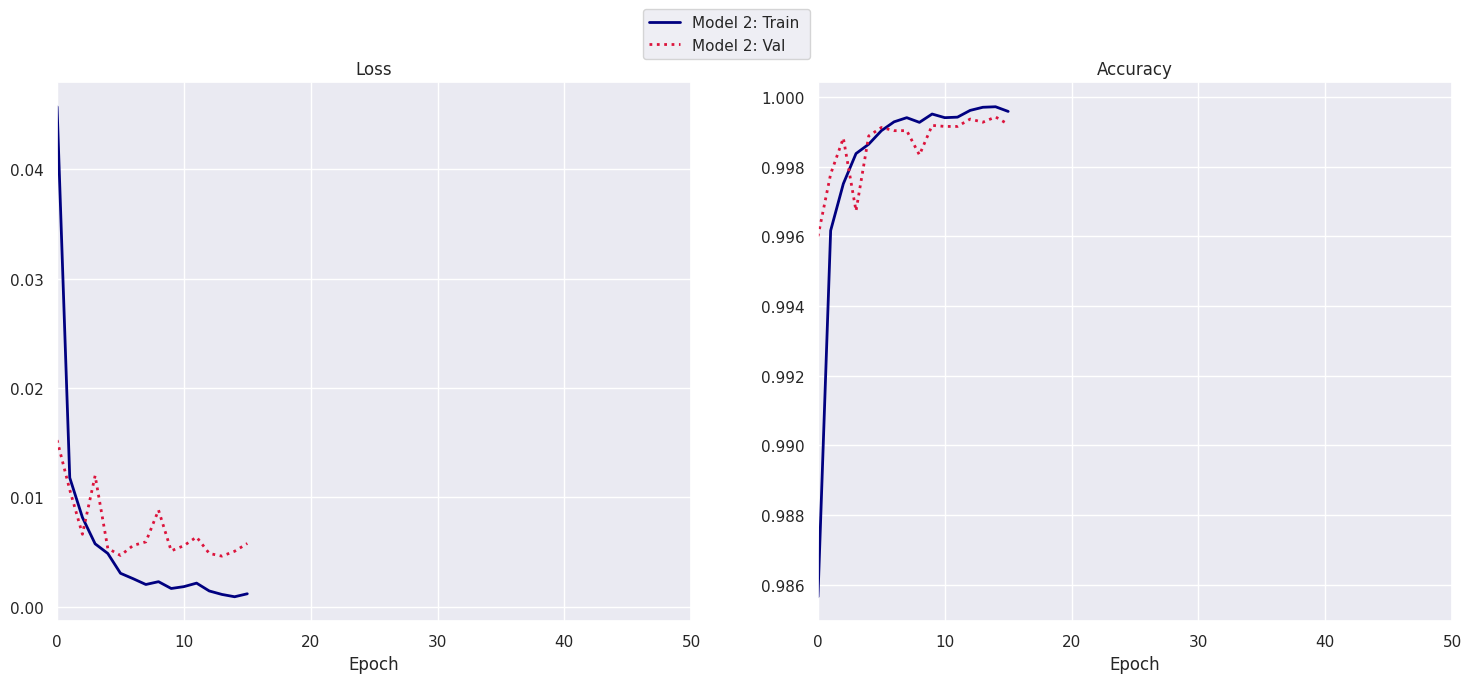

In [25]:
fig = plt.figure(figsize=(18, 7), facecolor='w', edgecolor='k')
gs  = gridspec.GridSpec(nrows=1, ncols=2)
ax = plt.subplot(gs[0, 0]), plt.subplot(gs[0, 1])

colors_list = ["crimson", "orchid", "navy", "aqua"]

num=2
l1 = ax[0].plot(hist.history['loss'], c=colors_list[num] ,label='Model '+str(num)+': Train ', linewidth=2)
ax[0].plot(hist.history['val_loss'], ls='dotted', c=colors_list[0], label='Model '+str(num)+': Val', linewidth=2)

ax[1].plot(hist.history['categorical_accuracy'], c=l1[0].get_color(), linewidth=2)
ax[1].plot(hist.history['val_categorical_accuracy'], ls='dotted', c=colors_list[0], linewidth=2)

# labels
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_xlim([0, 50])
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_xlim([0, 50])

handles, labels = ax[0].get_legend_handles_labels()
plt.legend(labels, loc="best", bbox_to_anchor=(0, 1.15))
plt.show()